## WS25: Seminar: Business Analytics (Master) - BWL 12
### Topic: Supply Chain Resilience under Disruptions — An Agent-Based Simulation with Mesa

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from model import MultiTierModel

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
# ---------------------------
# Assumptions & strategies
# ---------------------------
assumptions = {
"n_suppliers": 2,
"n_plants": 1,
"n_dcs": 1,
"n_retailers": 3,
"base_stock": {"supplier": 70, "plant": 50, "dc": 40, "retailer": 20},
"capacity": {"supplier": 20, "plant": 15, "dc": 10, "retailer": 0},
"lead_time": {"supplier": 1, "plant": 5, "dc": 5, "retailer": 3},
"capacity_loss_frac": 0.1,
"recovery_duration": 2,
"holding_cost": 1.0,
"backlog_cost": 5.0,
"retailer_demand_mean": 5.0
}

strategy_configs = {
"baseline": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": False},
"dual_only": {"dual_sourcing": True, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": False},
"safety_only": {"dual_sourcing": False, "safety_stock_factor": 1.2, "flexible_capacity": False, "dynamic_reallocation": False},
"flex_only": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": True, "dynamic_reallocation": False},
"dynalloc_only": {"dual_sourcing": False, "safety_stock_factor": 1.0, "flexible_capacity": False, "dynamic_reallocation": True}
}

n_steps = 80
disruption_step = 20
scenarios = ["capacity_loss", "lead_time_surge", "demand_spike"]

results = {}

for scenario in scenarios:
    print(f"\n=== Scenario: {scenario} ===")
    for sname, sconf in strategy_configs.items():
        print(f" Running strategy: {sname}")

    # create model
        model = MultiTierModel(assumptions=assumptions, seed=SEED, 
                            strategies=sconf, disruption_at_step=disruption_step, scenario=scenario)
        
        # tracking metrics per step
        fill_rates = []
        total_costs = []
        orders_tier = []
        production_tier = []
        
        for t in range(n_steps):
            model.step()
            fill_rates.append(model.compute_fill_rate())
            total_costs.append(model.compute_total_cost())
            orders_tier.append(model.get_orders_by_tier())
            production_tier.append(model.get_production_by_tier())
        
        # convert to DataFrame
        df = pd.DataFrame({
            "step": range(n_steps), 
            "fill_rate": fill_rates, 
            "total_cost": total_costs
        })
        orders_df = pd.DataFrame(orders_tier)
        production_df = pd.DataFrame(production_tier)
        
        bullwhip = model.compute_bullwhip()
        backlog_duration = model.compute_backlog_duration()
        ttr = model.compute_time_to_recover(target_frac=0.95)
        
        results[(scenario, sname)] = {
            "df": df,
            "orders": orders_df,
            "production": production_df,
            "bullwhip": bullwhip,
            "backlog_duration": backlog_duration,
            "ttr": ttr
        }
        
        print(f"  Final fill: {fill_rates[-1]:.3f} | total_cost: {total_costs[-1]:.1f} | "
            f"bullwhip: {bullwhip:.3f} | backlog_dur: {backlog_duration:.1f} | TTR: {ttr}")


=== Scenario: capacity_loss ===
 Running strategy: baseline
[Disruption] t=20 scenario=capacity_loss victim=<Firm 0 supplier Inv:70 Bk:0 Pipe:0> baseline_fill=0.7553199950969411
  Final fill: 0.475 | total_cost: 131131.0 | bullwhip: 0.000 | backlog_dur: 75.0 | TTR: nan
 Running strategy: dual_only
[Disruption] t=20 scenario=capacity_loss victim=<Firm 2 plant Inv:50 Bk:0 Pipe:0> baseline_fill=0.7553199950969411
  Final fill: 0.475 | total_cost: 131129.0 | bullwhip: 0.000 | backlog_dur: 75.0 | TTR: nan
 Running strategy: safety_only
[Disruption] t=20 scenario=capacity_loss victim=<Firm 0 supplier Inv:84 Bk:0 Pipe:0> baseline_fill=0.8469519961201453
  Final fill: 0.565 | total_cost: 110706.0 | bullwhip: 0.000 | backlog_dur: 73.7 | TTR: nan
 Running strategy: flex_only
[Disruption] t=20 scenario=capacity_loss victim=<Firm 0 supplier Inv:84 Bk:0 Pipe:0> baseline_fill=0.8469519961201453
  Final fill: 0.565 | total_cost: 110715.0 | bullwhip: 0.000 | backlog_dur: 73.7 | TTR: nan
 Running stra

In [3]:
summary_data = []
for (scenario, sname), res in results.items():
    df = res["df"]
    summary_data.append({
    "Scenario": scenario,
    "Strategy": sname,
    "Final Fill Rate": df["fill_rate"].iloc[-1],
    "Final Total Cost": df["total_cost"].iloc[-1],
    "Bullwhip": res["bullwhip"],
    "Backlog Duration": res["backlog_duration"],
    "TTR": res["ttr"],
    })

summary_df = pd.DataFrame(summary_data)
pd.set_option('display.float_format', '{:.2f}'.format)
print(summary_df)

           Scenario       Strategy  Final Fill Rate  Final Total Cost  \
0     capacity_loss       baseline             0.48         131131.00   
1     capacity_loss      dual_only             0.48         131129.00   
2     capacity_loss    safety_only             0.56         110706.00   
3     capacity_loss      flex_only             0.56         110715.00   
4     capacity_loss  dynalloc_only             0.58         107669.00   
5   lead_time_surge       baseline             0.56         110706.00   
6   lead_time_surge      dual_only             0.55         114305.00   
7   lead_time_surge    safety_only             0.67          88708.00   
8   lead_time_surge      flex_only             0.67          88718.00   
9   lead_time_surge  dynalloc_only             0.68          85362.00   
10     demand_spike       baseline             0.66          96399.00   
11     demand_spike      dual_only             0.66          96399.00   
12     demand_spike    safety_only             0.78

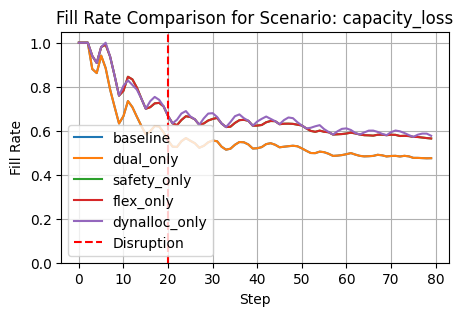

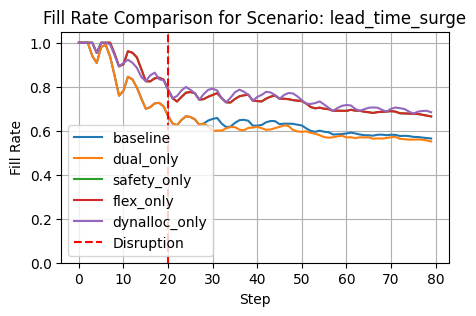

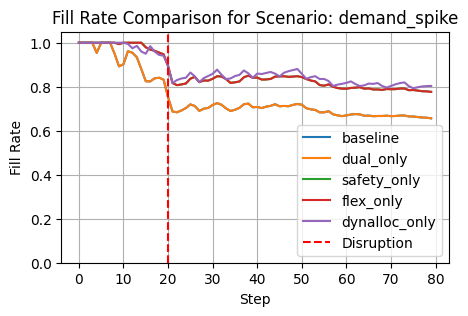

In [7]:
for scenario in scenarios:
    plt.figure(figsize=(5,3))
    for sname in strategy_configs.keys():
        fill_rate_series = results[(scenario, sname)]["df"]["fill_rate"]
        plt.plot(fill_rate_series, label=sname)
    plt.axvline(x=disruption_step, color='red', linestyle='--', label='Disruption')
    plt.xlabel("Step")
    plt.ylabel("Fill Rate")
    plt.title(f"Fill Rate Comparison for Scenario: {scenario}")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

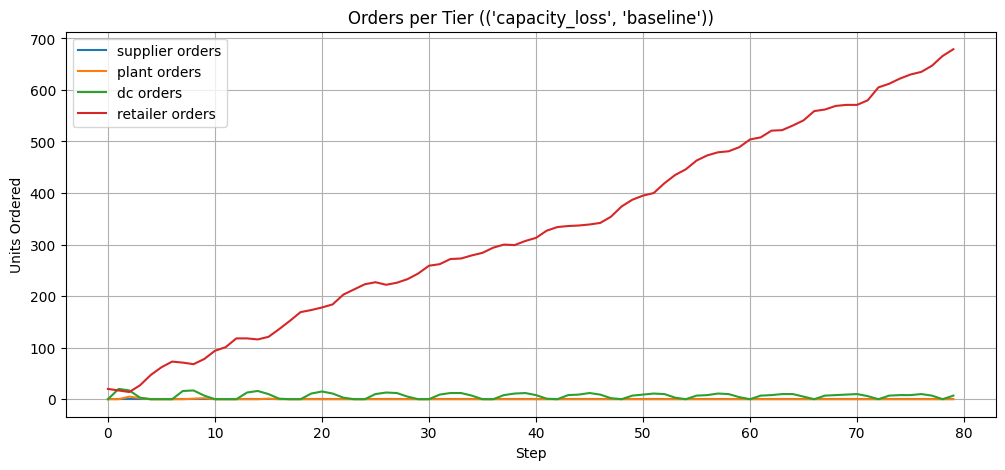

In [ ]:
example = list(results.keys())[0]
orders_df = results[example]["orders"]

plt.figure(figsize=(12,5))
for tier in ["supplier","plant","dc","retailer"]:
    plt.plot(orders_df[tier], label=f"{tier} orders")
plt.xlabel("Step")
plt.ylabel("Units Ordered")
plt.title(f"Orders per Tier ({example})")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
for t in range(n_steps):
    model.step()
    print("Step", t)
    print("Retailer order:", model.get_orders_by_tier()["retailer"])

Step 0
Retailer order: 331
Step 1
Retailer order: 341
Step 2
Retailer order: 353
Step 3
Retailer order: 343
Step 4
Retailer order: 341
Step 5
Retailer order: 345
Step 6
Retailer order: 347
Step 7
Retailer order: 357
Step 8
Retailer order: 374
Step 9
Retailer order: 362
Step 10
Retailer order: 363
Step 11
Retailer order: 365
Step 12
Retailer order: 365
Step 13
Retailer order: 383
Step 14
Retailer order: 395
Step 15
Retailer order: 391
Step 16
Retailer order: 389
Step 17
Retailer order: 389
Step 18
Retailer order: 383
Step 19
Retailer order: 392
Step 20
Retailer order: 408
Step 21
Retailer order: 401
Step 22
Retailer order: 405
Step 23
Retailer order: 402
Step 24
Retailer order: 398
Step 25
Retailer order: 414
Step 26
Retailer order: 432
Step 27
Retailer order: 433
Step 28
Retailer order: 435
Step 29
Retailer order: 435
Step 30
Retailer order: 437
Step 31
Retailer order: 450
Step 32
Retailer order: 468
Step 33
Retailer order: 465
Step 34
Retailer order: 469
Step 35
Retailer order: 471
St